# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 7. Решающие деревья и случайные леса.

**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**. Если вы строите интерактивные графики, их стоит прислать в формате html.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.




**Баллы за задание:**

* Задача 1 &mdash; 15 баллов
* Задача 2 &mdash; 50 баллов
* Задача 3 &mdash; 30 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
!sudo apt-get update
!sudo apt install graphviz -y

Get:1 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 https://ppa.launchpadcontent.net/criu/ppa/ubuntu jammy InRelease [18.0 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy/restricted amd64 Packages [164 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [17.5 MB]
Get:8 http://archive.ubuntu.com/ubuntu jammy/main amd64 Packages [1,792 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [266 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [28.6 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,251 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [962 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/un

In [2]:
# Bot check

# HW_ID: fpmi_ad7
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import scipy.stats
import warnings
from tqdm import tqdm_notebook

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [4]:
from sklearn import datasets
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn import preprocessing


warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None

Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/trees.html">ноутбук</a> с занятия по решающим деревьям.

---
### Задача 1.

Перед обучением линейной регрессии вы могли совершать некоторые преобразования над признаками. Какие преобразования стоит совершить перед обучением решающего дерева?

В частности, ответьте на вопрос, имеет ли смысл применять следующие преобразования:
* монотонные функции от одного признака;
* немонотонные функции от одного признака;
* линейные функции от нескольких признаков;
* нелинейные функции от нескольких признаков;
* стандартизация признаков;
* преобразования категориальных признаков.

**Ответ:**

Никакие функциональные преобразования над признаками совершать не надо для решающего дерева: мы можем потерять истинность модели относительно исходных данных. Обязательно необходима стандартизация, чтобы получить "гладкие" данные. Категориальные признаки так же необходимо преобразовывать, но только не через One-Hot-Encoding

---
### Задача 2.

Рассмотрим данные из <a href="https://miptstats.github.io/courses/ad_fivt/task6.html" target="_blank">предыдущего домашнего задания</a>. Скачайте данные и разделите их на три части &mdash; обучающую, валидационную и тестовую в соотношении 3:1:1.

In [5]:
data = pd.read_csv("day.csv")
data = data.drop(columns=['atemp','dteday', 'instant', 'yr', 'casual', 'registered'])

#Разделим на категориальные и количественные признаки
categorial_features = ['season', 'mnth', 'weekday']
real_features = ['holiday', 'workingday', 'weathersit',
       'temp', 'hum', 'windspeed']
all_features = categorial_features + real_features
target_feature = 'cnt'

In [6]:
train, test = train_test_split(data, test_size=0.2)
train, validate = train_test_split(train, test_size=0.25)

Выполните необходимые преобразования признаков.

*Замечание.* Если в валидационной и/или тестовой частях есть "большие" выбросы, их стоит убрать. Наша модель не должна пытаться их предсказать, но в то же время выбросы вносят существенный вклад в значение метрики. 

Выполним следующие преобразования:

1. Очистим данные от выбросов;
   
   Воспользуемся результатами прошлого задания: удалим по 2% с обеих концов датафрейма
2. Закодируем категориальные признаки

    Важно понимать, что One-Hot-Encoding для данной модели может сделать данные слишком разреженными. А т.к. при работе с деревьями применяется решающее правило, а не линейная функция, то логичнее использовать Order Encoding. Конечно, проблему разреженности решается стандартизацией, но интересно сравнить два подхода по точности.
3. Стандартизируем данные

In [7]:
def trash(input_data):
    input_data = input_data[int(len(input_data)*0.02):]
    input_data = input_data[:int(len(input_data)*0.98)]

    return input_data

In [8]:
data_list = [train, test, validate]

#Избавляемся от выбросов
for df in data_list:
    df = trash(df)

#Стандартизируем данные
standartization =  preprocessing.MinMaxScaler()
train[real_features] = standartization.fit_transform(train[real_features])
    
test[real_features] = standartization.transform(test[real_features])
validate[real_features] = standartization.transform(validate[real_features])

Обучите решающее дерево глубины 3 и визуализируйте его. 

*Рекомендуется сохранить визуализацию в html и отправить ее вместе с решением.*

In [9]:
des_tree = DecisionTreeRegressor(max_depth=3, min_samples_split=10)
des_tree.fit(train[all_features], train[target_feature])

DecisionTreeRegressor(max_depth=3, min_samples_split=10)

In [10]:
def get_graphviz_graph(decision_tree_regressor, data, all_feat):
    '''
    Функция для обучения решающего дерева и построения
    по нему графа graphviz для визуализации
    '''
    
    dot_data = export_graphviz(
        decision_tree_regressor, out_file=None, 
        feature_names=data[all_feat].columns, class_names='cnt',  
        filled=True, rounded=True, special_characters=True
    )  
    return graphviz.Source(dot_data)  

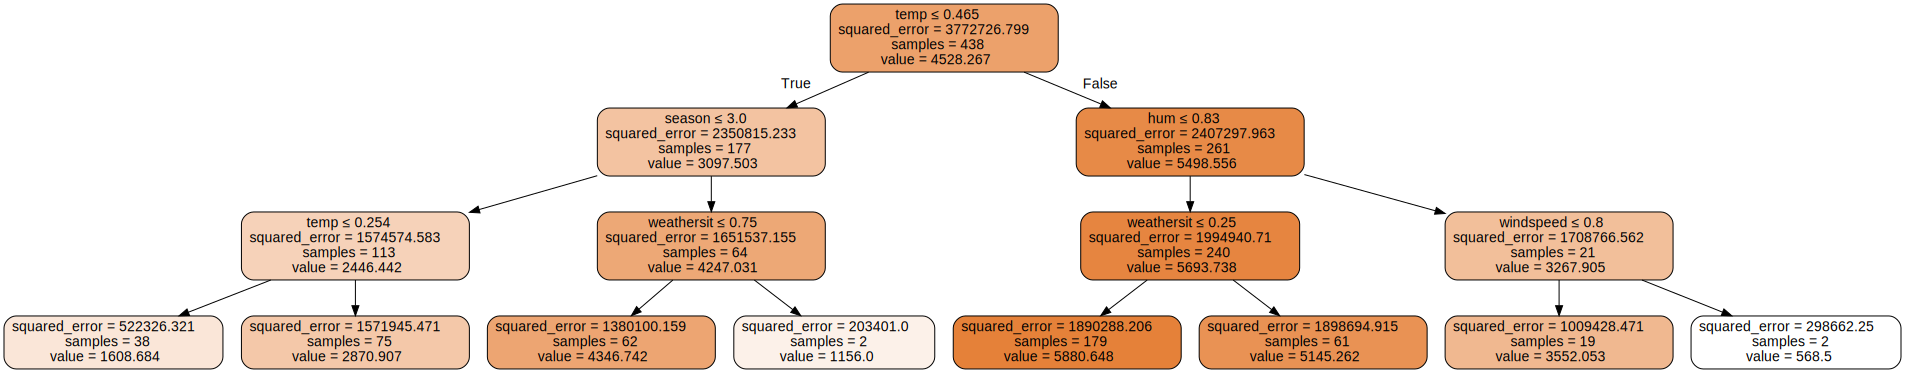

In [11]:
graph = get_graphviz_graph(des_tree, train, all_features)
graph

Подберите оптимальное значение максимальной глубины дерева. Для этого обучите решающие деревья с выставленным значением соответствующего гиперпараметра и посчитайте ошибку предсказаний каждого из них на валидационной выборке. Постройте соответствующий график.

In [12]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

4 32.76305834783672


Text(0.5, 1.0, 'Зависимость качества от глубины дерева по метрике MAPE')

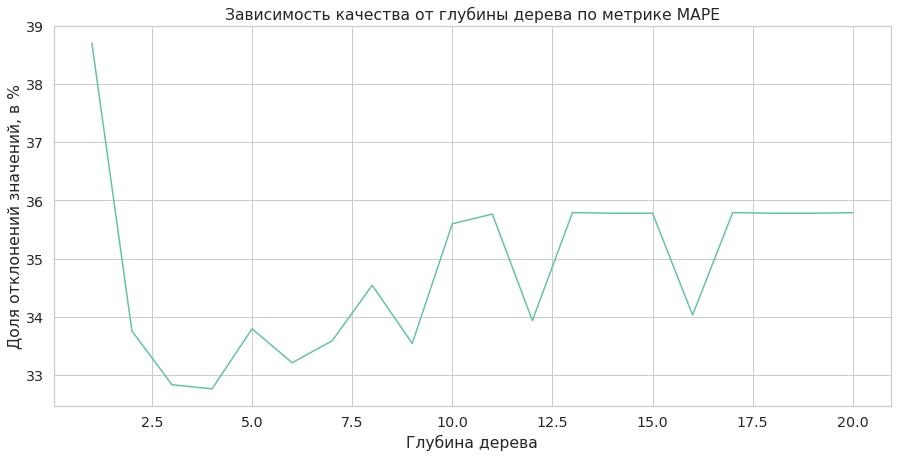

In [13]:
min_error = pow(10, 6)
best_depth = 0

graph_error = []
depth_values = []

for depth in list(range(1, 21)):
    des_tree = DecisionTreeRegressor(max_depth=depth, min_samples_split=10)
    des_tree.fit(train[all_features], train[target_feature])
    mape =  mean_absolute_percentage_error(validate[target_feature], des_tree.predict(validate[all_features]))
    if (mape < min_error):
        min_error = mape
        best_depth = depth

    graph_error.append(mape)
    depth_values.append(depth)

print(best_depth, min_error)

#Построим график
plt.figure(figsize=(15, 7))
plt.plot(depth_values, graph_error)    

plt.xlabel('Глубина дерева')
plt.ylabel('Доля отклонений значений, в %')
plt.title("Зависимость качества от глубины дерева по метрике MAPE")


Аналогичным образом подберите минимальное число объектов в листе, зафиксировав при этом подобранное значение максимальной глубины.

39 32.71882644917099


Text(0.5, 1.0, 'Зависимость качества от числа обьектов в листе по метрике MAPE')

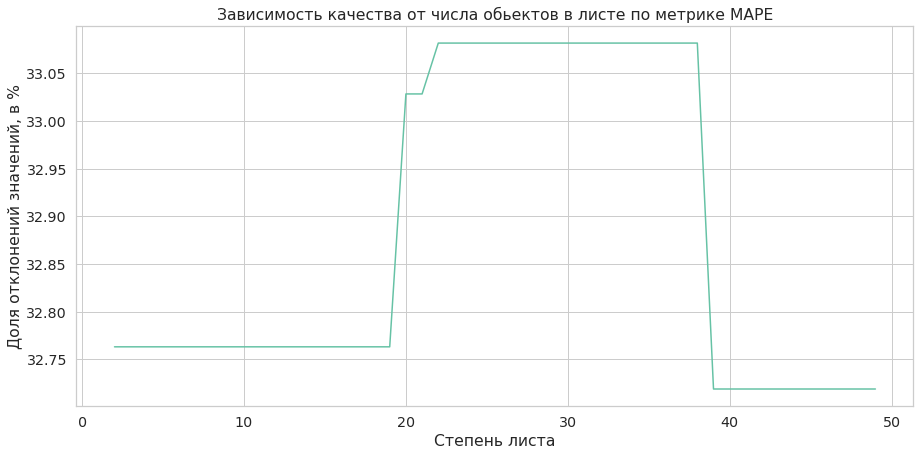

In [14]:
min_error = pow(10, 6)
best_split = 0

graph_error = []
split_values = []

for split in list(range(2, 50)):
    des_tree = DecisionTreeRegressor(max_depth=best_depth, min_samples_split=split)
    des_tree.fit(train[all_features], train[target_feature])
    mape = mean_absolute_percentage_error(validate[target_feature], des_tree.predict(validate[all_features]))
    if (mape < min_error):
        min_error = mape
        best_split = split

    graph_error.append(mape)
    split_values.append(split)

print(best_split, min_error)

#Построим график
plt.figure(figsize=(15, 7))
plt.plot(split_values, graph_error)    

plt.xlabel('Степень листа')
plt.ylabel('Доля отклонений значений, в %')
plt.title("Зависимость качества от числа обьектов в листе по метрике MAPE")

Визуализируйте дерево при оптимальных гиперпараметрах и посчитайте его ошибку на тестовой части выборки.

In [15]:
des_tree = DecisionTreeRegressor(max_depth=best_depth, min_samples_split=best_split)
des_tree.fit(train[all_features], train[target_feature])

print("Ошибка на тестовой выборке", mean_absolute_percentage_error(test[target_feature], des_tree.predict(test[all_features]))) 


Ошибка на тестовой выборке 31.307522799999543


Решающее дерево позволяет оценить *важность признаков* &mdash; некоторая величина, зависящая от того
* насколько часто тот или иной признак использовался при разбиении листа, 
* и насколько сильно при этом изменился критерий информативности.

У обученной модели значения важности признаков лежат в поле `feature_importances_`. Визуализируйте их с помощью `seaborn.barplot`.

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

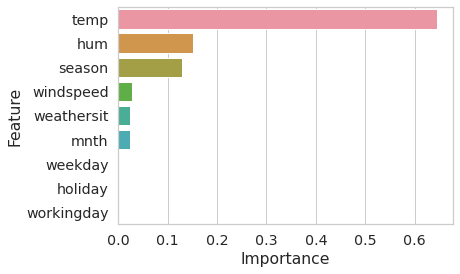

In [16]:
importances = des_tree.feature_importances_
feat_imp = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feat_imp)

**Выводы:**

После значения 10 обоих гиперпараметров, качество сильно падает - происходит переобучение. Идеальной глубиной дерева является значение 5, идеальным количеством обьектов - 39. Из визуализации дерева интересно отметить, что на количество арендованных велосипедов прежде всего влияют погодные параметры: влажность, температура, скорость ветра. Выходной это, или нет, не влияет вообще, хотя в прошлом задании мы обращали на это внимание. Самым важным признаком стала температура. 

В целом качество модели наравне с хорошо настроенной линейной регрессией.

---
### Задача 3.

Для данных из предыдущей части обучите случайный лес на 500 деревьев.

In [17]:
n_estimators = 500
forest = RandomForestRegressor(n_estimators=n_estimators)
forest.fit(train[all_features], train[target_feature])
print("Ошибка на тестовой выборке", mean_absolute_percentage_error(test[target_feature], forest.predict(test[all_features]))) 

Ошибка на тестовой выборке 29.455992809667926


Постройте график зависимости ошибки модели в зависимости от количества деревьев для обучающей и валидационной выборок.

*Замечание.* Не нужно заново обучать лес каждый раз. Используйте у *обученной* модели поле `estimators_`, это список из объектов класса `DecisionTreeRegressor`. Обратите внимание, что это приватное поле объекта, и менять его очень плохо, за такое баллы будут снижаться.

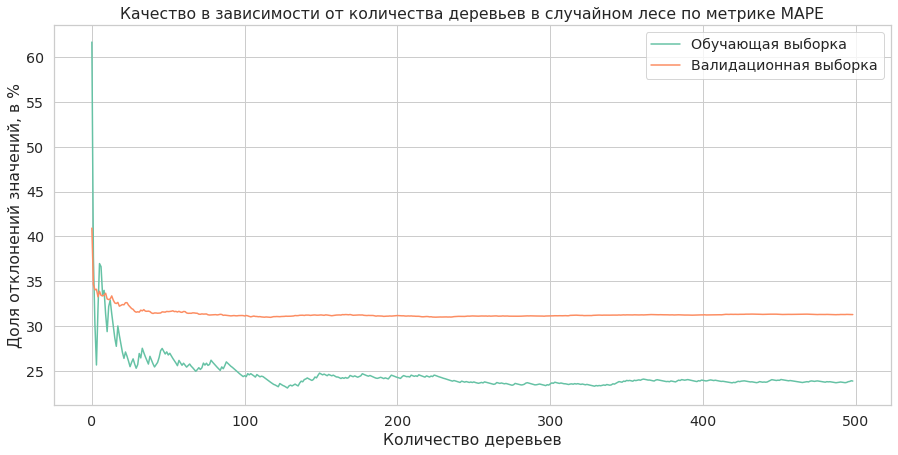

In [18]:
presum_train = 0
rslt_list_train = []

presum_valid = 0
rslt_list_valid = []

for i in range(1, len(forest.estimators_)):
    presum_train += forest.estimators_[i].predict(train[all_features])
    rslt_list_train.append(mean_absolute_percentage_error(train[target_feature], presum_train/i))

    presum_valid += forest.estimators_[i].predict(validate[all_features])
    rslt_list_valid.append(mean_absolute_percentage_error(validate[target_feature], presum_valid/i))

plt.figure(figsize=(15, 7))
plt.plot(range(len(rslt_list_train)), rslt_list_train, label='Обучающая выборка')    
plt.plot(range(len(rslt_list_valid)), rslt_list_valid, label='Валидационная выборка')    

plt.xlabel('Количество деревьев')
plt.ylabel('Доля отклонений значений, в %')
plt.title("Качество в зависимости от количества деревьев в случайном лесе по метрике MAPE")
plt.legend()

Для леса с максимальным количеством деревьев визуализируйте
важность признаков, используя поле `feature_importances_`. 

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

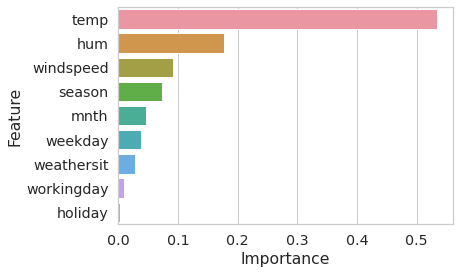

In [19]:
importances = forest.feature_importances_
feat_imp = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feat_imp)

**Выводы:**

Во-первых, качество в случайном лесе улучшилось, до 29%. Из графика видно, что с увеличением количества деревеьев в лесу, значение ошибки сходится к какому-то конкретному.

Видно, что, в сравнении с одним решающим деревом, значимость всех признаков значительно подросла, а важность признака "temp" занимает почти половину.